##Modelo TCN para filtro pasa banda

Subir Dataset

In [ ]:
import torch
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/bpf_cascade_30k.pt'
data = torch.load(data_path, weights_only=False)

# Ver composición
print("Composición del Dataset")
print(f"Claves disponibles: {data.keys()}")
print(f"N de muestras: {len(data['x'])}")

# Ver dimensiones de una muestra
sample_x = data['x'][0]
sample_y = data['y'][0]

print("\n Dimensiones de una muestra")
print(f"Audio entrada: {sample_x['audio_in'].shape}") # Debería ser (n_samples,)
print(f"Audio salida: {sample_y.shape}")            # Debería ser (n_samples,)
print(f"Cantidad de Knobs: {len(sample_x['knobs'])}")
print(f"Knobs: {sample_x['knob_names']}")

Mounted at /content/drive
Composición del Dataset
Claves disponibles: dict_keys(['x', 'y', 'fs', 'meta', 'recipe', 'seed'])
N de muestras: 29371

 Dimensiones de una muestra
Audio entrada: (960,)
Audio salida: (960,)
Cantidad de Knobs: 5
Knobs: ['R_gain', 'C_hp', 'R_lpf', 'C_lpf', 'R_load']


DataLoader

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from IPython.testing import test
import torch.nn as nn
class KaspixDataset(Dataset):
    def __init__(self, data_path):
        checkpoint = torch.load(data_path, weights_only=False)

        # 1. Procesar audios de entrada
        print("Procesando audios...")
        self.x_audio = torch.stack([
            torch.from_numpy(np.array(item['audio_in'], dtype=np.float32)).unsqueeze(0)
            for item in checkpoint['x']
        ])

        # 2. Procesar audios de salida (Target)
        self.y = torch.stack([
            torch.from_numpy(np.array(item, dtype=np.float32)).unsqueeze(0)
            for item in checkpoint['y']
        ])

        # 3. Extraer Knobs (CORREGIDO)
        # Iteramos sobre cada muestra en checkpoint['x'] para sacar sus knobs específicos
        print("Extrayendo knobs por muestra...")
        self.x_knobs = torch.stack([
            torch.from_numpy(np.array(item['knobs'], dtype=np.float32))
            for item in checkpoint['x']
        ])

        # 4. Normalización
        self.knob_mean = self.x_knobs.mean(dim=0, keepdim=True)
        self.knob_std = self.x_knobs.std(dim=0, keepdim=True)
        self.x_knobs = (self.x_knobs - self.knob_mean) / (self.knob_std + 1e-8)

        print(f"\n¡Dataset Corregido y Cargado!")
        print(f"- Audio Input: {self.x_audio.shape}")   # Debería ser (29371, 1, 960)
        print(f"- Knobs Matrix: {self.x_knobs.shape}") # Debería ser (29371, 5) <- ESTO ES LO IMPORTANTE
        print(f"- Audio Target: {self.y.shape}")       # Debería ser (29371, 1, 960)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_audio[idx], self.x_knobs[idx], self.y[idx]

In [ ]:

# Cargar y dividir (80% tren, 10% val, 10% test)
full_ds = KaspixDataset(data_path)
knob_mean = full_ds.x_knobs.mean(dim=0)
knob_std = full_ds.x_knobs.std(dim=0)
total_samples = len(full_ds)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size],
                                         generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

Procesando audios...
Extrayendo knobs por muestra...

¡Dataset Corregido y Cargado!
- Audio Input: torch.Size([29371, 1, 960])
- Knobs Matrix: torch.Size([29371, 5])
- Audio Target: torch.Size([29371, 1, 960])


Arquitectura

In [ ]:
class FiLM(nn.Module):
    def __init__(self, channels, knob_dim):
        super().__init__()
        self.gen = nn.Linear(knob_dim, channels * 2)

    def forward(self, x, knobs):
        params = self.gen(knobs).unsqueeze(2)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TCN(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size,
                              padding=self.padding,
                              dilation=dilation)
        self.film = FiLM(out_ch, knob_dim)
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)
        x = self.conv(x)

        if self.padding > 0:
            x = x[:, :, :-self.padding]

        x = self.film(x, knobs)
        x = self.norm(x)
        return self.act(x) + res

class KaspixTCN(nn.Module):
    def __init__(self, num_knobs=5):
        super().__init__()

        self.channels = 64
        self.num_layers = 12 #10 son suficientes para 960 samples
        self.layers = nn.ModuleList()
        self.layers.append(TCN(1, self.channels, 3, 1, num_knobs))

        for i in range(1, self.num_layers):
            dilation = 2 ** i
            self.layers.append(TCN(self.channels, self.channels, 3, dilation, num_knobs))

        self.output = nn.Conv1d(self.channels, 1, kernel_size=1)

    def forward(self, audio, knobs):
        x = audio
        for layer in self.layers:
            x = layer(x, knobs)
        return self.output(x)

Entrenamiento

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

def calculate_esr(pred, target):
    return torch.sum((target - pred)**2) / (torch.sum(target**2) + 1e-9)

def calculate_lsd(pred, true, fs=44100):
    Y_true = torch.fft.rfft(true, dim=-1).abs() + 1e-8
    Y_pred = torch.fft.rfft(pred, dim=-1).abs() + 1e-8
    log_diff = torch.log10(Y_true ** 2) - torch.log10(Y_pred ** 2)
    lsd = torch.sqrt(torch.mean(log_diff ** 2, dim=-1))
    return torch.mean(lsd)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'best_kaspix_pasabanda.pth'

if len(full_ds.x_knobs.shape) == 1:
    full_ds.x_knobs = full_ds.x_knobs.view(-1, 5)
num_inputs_knobs = full_ds.x_knobs.shape[1]
print(f'numero de knobs: {num_inputs_knobs}')

model = KaspixTCN(num_knobs=num_inputs_knobs).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Added weight_decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=4)
criterion = nn.MSELoss()

print(f" Iniciando entrenamiento Pasa Banda ({num_inputs_knobs} knobs) en {device}...")

best_score = float('inf')
patience_counter = 0
patience = 20 # Ajustado para un entrenamiento más ágil
epochs = 60   # Más épocas porque 5 parámetros requieren más exploración

for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}", leave=False)

    for x_audio, x_knobs, y_true in pbar:
        x_audio, x_knobs, y_true = x_audio.to(device), x_knobs.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_audio, x_knobs)

        # Pérdida híbrida: MSE para el tiempo + un pequeño factor de ESR
        loss_mse = criterion(y_pred, y_true)
        # El ESR ayuda a que el modelo no se obsesione con el volumen sino con la forma
        loss_esr = calculate_esr(y_pred, y_true)
        loss = loss_mse + (0.1 * loss_esr)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip más estricto
        optimizer.step()

        train_loss += loss.item()

        if pbar.n % 10 == 0: # Actualizar pbar cada 10 pasos para no saturar
            with torch.no_grad():
                esr_val = calculate_esr(y_pred, y_true)
                lsd_val = calculate_lsd(y_pred, y_true)
            pbar.set_postfix(loss=f"{loss.item():.5f}", esr=f"{esr_val.item():.4f}", lsd=f"{lsd_val.item():.3f}")

    # --- 5. Fase de Validación ---
    model.eval()
    val_mse, val_esr, val_lsd = 0, 0, 0

    with torch.no_grad():
        for x_a, x_k, y_t in val_loader:
            x_a, x_k, y_t = x_a.to(device), x_k.to(device), y_t.to(device)
            y_p = model(x_a, x_k)

            val_mse += criterion(y_p, y_t).item()
            val_esr += calculate_esr(y_p, y_t).item()
            val_lsd += calculate_lsd(y_p, y_t).item()

    avg_mse = val_mse / len(val_loader)
    avg_esr = val_esr / len(val_loader)
    avg_lsd = val_lsd / len(val_loader)

    scheduler.step(avg_mse)

    # El SCORE para decidir si el modelo es mejor: Prioriza ESR y LSD
    # Le damos peso al LSD porque en Pasa Banda la curva de frecuencia es vital
    score_actual = avg_esr + (avg_lsd / 5)

    print(f"\n Época {epoch+1}: MSE: {avg_mse:.6f} | ESR: {avg_esr:.6f} | LSD: {avg_lsd:.4f}")

    # --- 6. Guardado del mejor modelo ---
    if score_actual < best_score:
        best_score = score_actual
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_esr': avg_esr,
            'val_lsd': avg_lsd,
            'knob_mean': full_ds.knob_mean, # Guardamos normalización
            'knob_std': full_ds.knob_std
            }, checkpoint_path)
        print(f" ¡Nuevo Récord! Score: {score_actual:.6f}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping activado.")
        break

print(f" Entrenamiento finalizado. Mejor Score: {best_score:.6f}")

numero de knobs: 5
 Iniciando entrenamiento Pasa Banda (5 knobs) en cuda...


Época 1/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 1: MSE: 0.006739 | ESR: 0.226792 | LSD: 1.1622
 ¡Nuevo Récord! Score: 0.459238


Época 2/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 2: MSE: 0.005461 | ESR: 0.183803 | LSD: 1.0702
 ¡Nuevo Récord! Score: 0.397844


Época 3/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 3: MSE: 0.004418 | ESR: 0.147522 | LSD: 1.0212
 ¡Nuevo Récord! Score: 0.351771


Época 4/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 4: MSE: 0.003580 | ESR: 0.119324 | LSD: 0.9859
 ¡Nuevo Récord! Score: 0.316506


Época 5/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 5: MSE: 0.004004 | ESR: 0.135409 | LSD: 0.9373


Época 6/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 6: MSE: 0.002638 | ESR: 0.088877 | LSD: 0.8799
 ¡Nuevo Récord! Score: 0.264853


Época 7/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 7: MSE: 0.002059 | ESR: 0.069038 | LSD: 0.8552
 ¡Nuevo Récord! Score: 0.240073


Época 8/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 8: MSE: 0.001452 | ESR: 0.048254 | LSD: 0.8451
 ¡Nuevo Récord! Score: 0.217267


Época 9/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 9: MSE: 0.004828 | ESR: 0.164670 | LSD: 0.8138


Época 10/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 10: MSE: 0.001788 | ESR: 0.059993 | LSD: 0.7636
 ¡Nuevo Récord! Score: 0.212710


Época 11/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 11: MSE: 0.001206 | ESR: 0.040287 | LSD: 0.7559
 ¡Nuevo Récord! Score: 0.191468


Época 12/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 12: MSE: 0.001567 | ESR: 0.052785 | LSD: 0.7374


Época 13/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 13: MSE: 0.001472 | ESR: 0.049599 | LSD: 0.7183


Época 14/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 14: MSE: 0.001100 | ESR: 0.036993 | LSD: 0.7004
 ¡Nuevo Récord! Score: 0.177077


Época 15/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 15: MSE: 0.001008 | ESR: 0.033773 | LSD: 0.6944
 ¡Nuevo Récord! Score: 0.172643


Época 16/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 16: MSE: 0.000775 | ESR: 0.025897 | LSD: 0.6892
 ¡Nuevo Récord! Score: 0.163743


Época 17/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 17: MSE: 0.000861 | ESR: 0.029027 | LSD: 0.6721
 ¡Nuevo Récord! Score: 0.163444


Época 18/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 18: MSE: 0.000609 | ESR: 0.020291 | LSD: 0.6748
 ¡Nuevo Récord! Score: 0.155260


Época 19/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 19: MSE: 0.000879 | ESR: 0.029681 | LSD: 0.6840


Época 20/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 20: MSE: 0.000517 | ESR: 0.017391 | LSD: 0.6789
 ¡Nuevo Récord! Score: 0.153177


Época 21/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 21: MSE: 0.000600 | ESR: 0.020160 | LSD: 0.6639
 ¡Nuevo Récord! Score: 0.152949


Época 22/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 22: MSE: 0.000567 | ESR: 0.019095 | LSD: 0.6646
 ¡Nuevo Récord! Score: 0.152023


Época 23/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 23: MSE: 0.000672 | ESR: 0.022847 | LSD: 0.6678


Época 24/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 24: MSE: 0.000514 | ESR: 0.017405 | LSD: 0.6555
 ¡Nuevo Récord! Score: 0.148505


Época 25/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 25: MSE: 0.000675 | ESR: 0.022909 | LSD: 0.6697


Época 26/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 26: MSE: 0.000397 | ESR: 0.013383 | LSD: 0.6538
 ¡Nuevo Récord! Score: 0.144145


Época 27/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 27: MSE: 0.000787 | ESR: 0.026936 | LSD: 0.6610


Época 28/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 28: MSE: 0.000473 | ESR: 0.015861 | LSD: 0.6631


Época 29/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 29: MSE: 0.000533 | ESR: 0.018057 | LSD: 0.6659


Época 30/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 30: MSE: 0.000352 | ESR: 0.011974 | LSD: 0.6979


Época 31/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 31: MSE: 0.000372 | ESR: 0.012562 | LSD: 0.6931


Época 32/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 32: MSE: 0.000371 | ESR: 0.012647 | LSD: 0.7321


Época 33/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 33: MSE: 0.000353 | ESR: 0.012033 | LSD: 0.7238


Época 34/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 34: MSE: 0.000390 | ESR: 0.013345 | LSD: 0.7488


Época 35/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 35: MSE: 0.000349 | ESR: 0.011816 | LSD: 0.7454


Época 36/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 36: MSE: 0.000359 | ESR: 0.012242 | LSD: 0.7650


Época 37/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 37: MSE: 0.000222 | ESR: 0.007576 | LSD: 0.7523


Época 38/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 38: MSE: 0.000830 | ESR: 0.028021 | LSD: 0.7657


Época 39/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 39: MSE: 0.000231 | ESR: 0.007852 | LSD: 0.7641


Época 40/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 40: MSE: 0.000252 | ESR: 0.008612 | LSD: 0.7558


Época 41/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 41: MSE: 0.000254 | ESR: 0.008561 | LSD: 0.7639


Época 42/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 42: MSE: 0.000191 | ESR: 0.006468 | LSD: 0.7664


Época 43/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 43: MSE: 0.000219 | ESR: 0.007464 | LSD: 0.7494


Época 44/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 44: MSE: 0.000220 | ESR: 0.007408 | LSD: 0.7472


Época 45/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 45: MSE: 0.000572 | ESR: 0.019699 | LSD: 0.7633


Época 46/60:   0%|          | 0/368 [00:00<?, ?it/s]


 Época 46: MSE: 0.000608 | ESR: 0.020790 | LSD: 0.7714
Early stopping activado.
 Entrenamiento finalizado. Mejor Score: 0.144145


Gráficos

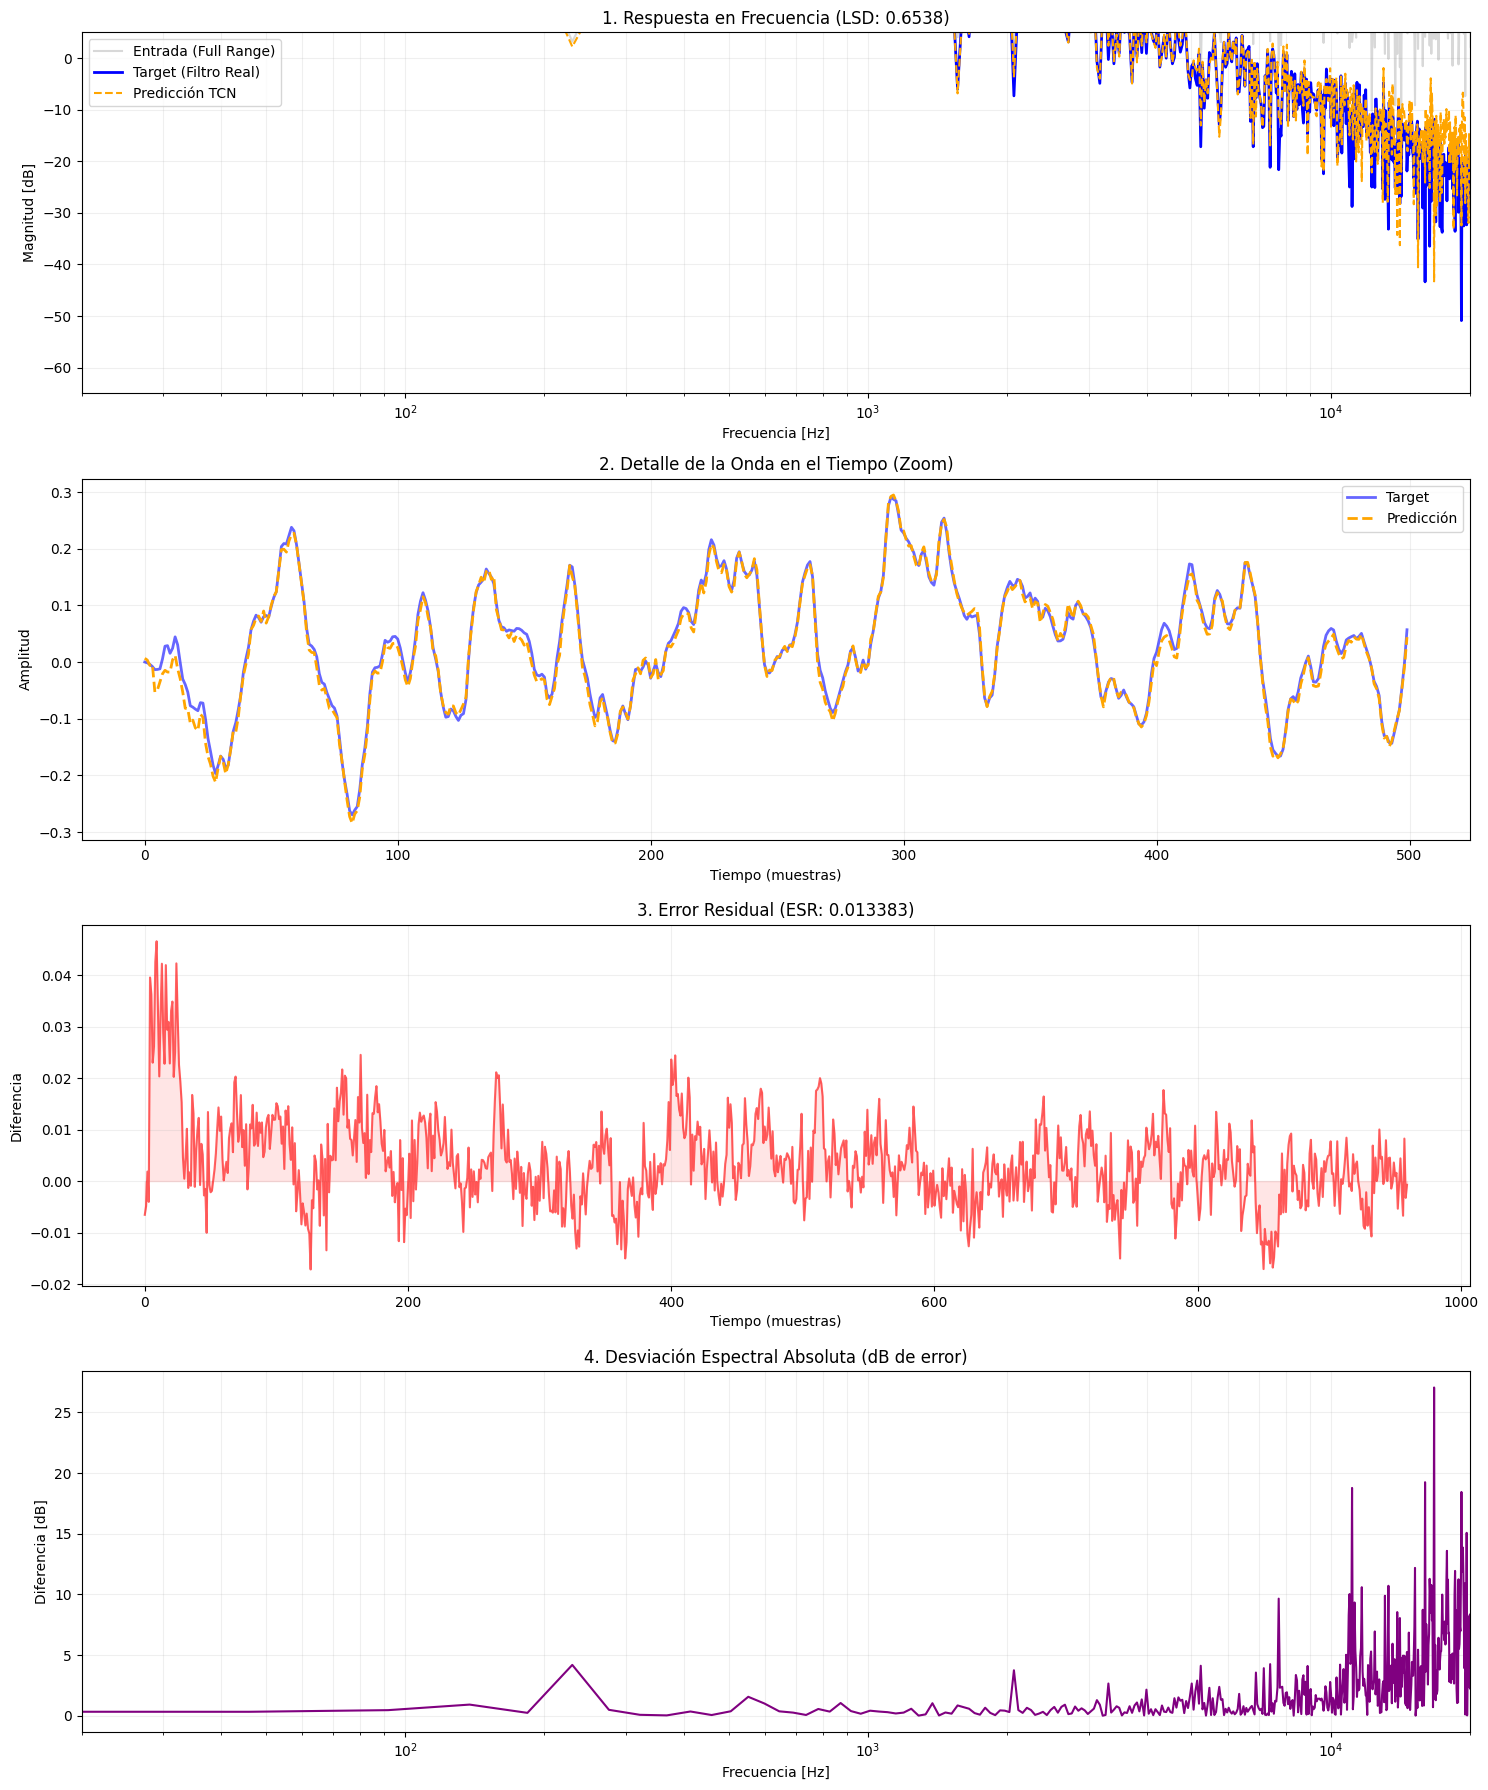

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparar el modelo y cargar pesos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_inputs_knobs = val_ds.dataset.x_knobs.shape[1]

model = KaspixTCN(num_knobs=num_inputs_knobs).to(device)
checkpoint = torch.load('best_kaspix_pasabanda.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 2. Extraer una muestra de validación
sample_idx = 1920
x_audio, x_knobs, y_true = val_ds[sample_idx]
x_audio_t = x_audio.unsqueeze(0).to(device)
x_knobs_t = x_knobs.unsqueeze(0).to(device)

with torch.no_grad():
    y_pred_t = model(x_audio_t, x_knobs_t)

# 3. Conversión a numpy para visualización
y_true_np = y_true.squeeze().cpu().numpy()
y_pred_np = y_pred_t.squeeze().cpu().numpy()
x_in_np = x_audio.squeeze().cpu().numpy()

# --- DASHBOARD DE RESULTADOS ---
plt.figure(figsize=(15, 18))

# A. RESPUESTA EN FRECUENCIA (FFT)
plt.subplot(4, 1, 1)
def get_magnitude_db(sig):
    return 20 * np.log10(np.abs(np.fft.rfft(sig)) + 1e-8)

freqs = np.fft.rfftfreq(len(y_true_np), 1/44100)
plt.plot(freqs, get_magnitude_db(x_in_np), color='gray', alpha=0.3, label='Entrada (Full Range)')
plt.plot(freqs, get_magnitude_db(y_true_np), color='blue', lw=2, label='Target (Filtro Real)')
plt.plot(freqs, get_magnitude_db(y_pred_np), color='orange', ls='--', label='Predicción TCN')
plt.xscale('log')
plt.xlim(20, 20000)
plt.ylim(-65, 5)
plt.title(f"1. Respuesta en Frecuencia (LSD: {checkpoint.get('val_lsd', 0):.4f})")
plt.ylabel("Magnitud [dB]")
plt.xlabel("Frecuencia [Hz]")
plt.legend()
plt.grid(True, which="both", alpha=0.2)

# B. ZOOM FORMA DE ONDA (Tiempo)
plt.subplot(4, 1, 2)
# Mostramos un fragmento central para ver la fase y amplitud
plt.plot(y_true_np[:500], label='Target', color='blue', alpha=0.6, lw=2)
plt.plot(y_pred_np[:500], label='Predicción', color='orange', ls='--', lw=2)
plt.title("2. Detalle de la Onda en el Tiempo (Zoom)")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True, alpha=0.2)

# C. ERROR RESIDUAL
plt.subplot(4, 1, 3)
error = y_true_np - y_pred_np
plt.plot(error, color='red', alpha=0.6)
plt.title(f"3. Error Residual (ESR: {checkpoint.get('val_esr', 0):.6f})")
plt.fill_between(range(len(error)), error, color='red', alpha=0.1)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia")
plt.grid(True, alpha=0.2)

# D. ERROR POR FRECUENCIA
plt.subplot(4, 1, 4)
diff_db = np.abs(get_magnitude_db(y_true_np) - get_magnitude_db(y_pred_np))
plt.plot(freqs, diff_db, color='purple')
plt.xscale('log')
plt.xlim(20, 20000)
plt.title("4. Desviación Espectral Absoluta (dB de error)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Diferencia [dB]")
plt.grid(True, which="both", alpha=0.2)

plt.tight_layout()
plt.show()

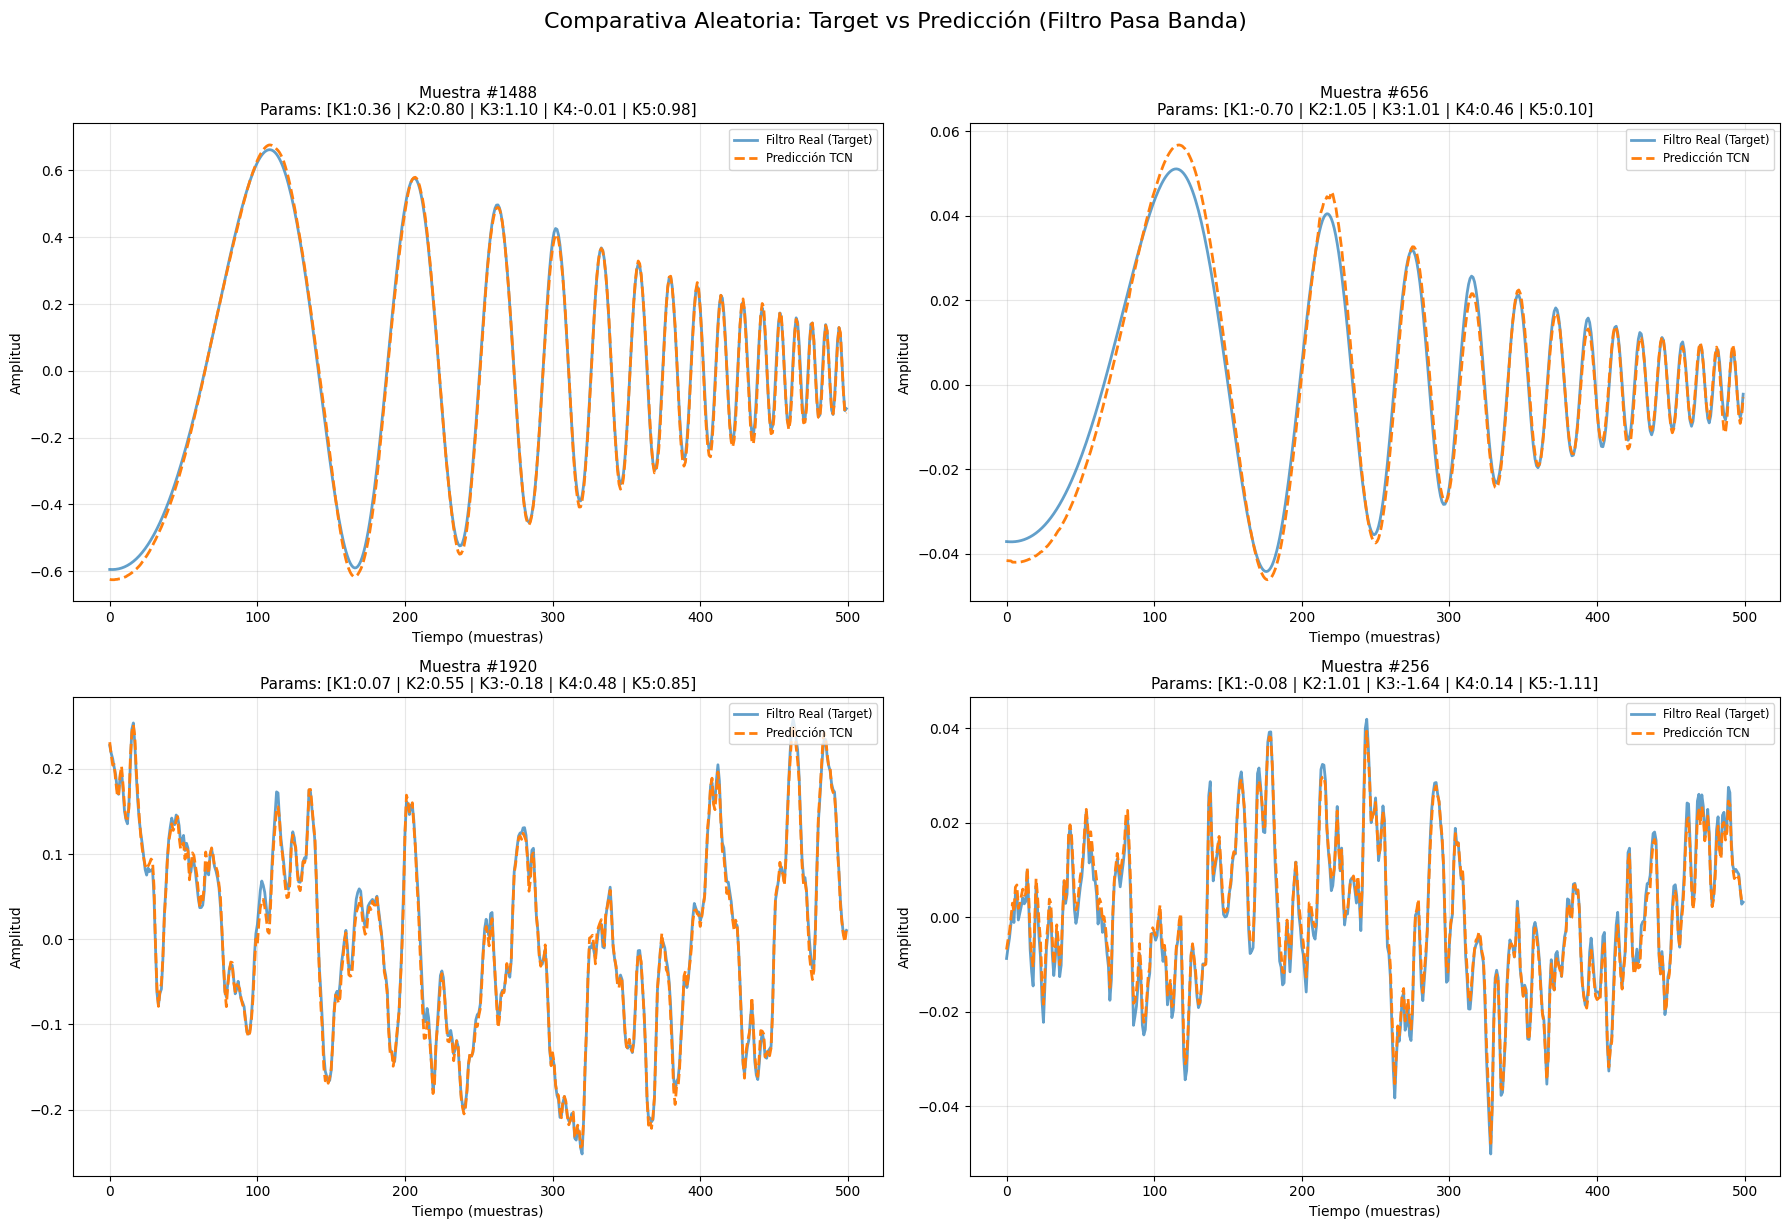

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def visualizar_comparativa_pasa_alto(model, dataset, device):
    model.eval()
    # Creamos una cuadrícula de 2x2 para que sea más fácil comparar
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

    # Seleccionamos 4 índices aleatorios del conjunto de validación o test
    indices = random.sample(range(len(dataset)), 4)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 1. Extraer datos del Subset de forma segura
            x_audio, x_knobs, y_true = dataset[idx]

            # 2. Preparar Tensores [Batch, Canales, Samples]
            x_audio_t = x_audio.unsqueeze(0).to(device)
            x_knobs_t = x_knobs.unsqueeze(0).to(device)

            # 3. Inferencia
            y_pred_t = model(x_audio_t, x_knobs_t)

            # 4. Pasar a Numpy
            y_true_np = y_true.squeeze().cpu().numpy()
            y_pred_np = y_pred_t.squeeze().cpu().numpy()
            knobs_vals = x_knobs.cpu().numpy()

            # 5. Graficar Forma de Onda (Dominio del Tiempo)
            ax = axes[i]
            # Hacemos zoom en un fragmento con actividad (muestras 300 a 800)
            start, end = 300, 800

            ax.plot(y_true_np[start:end], label='Filtro Real (Target)', color='#1f77b4', lw=2, alpha=0.7)
            ax.plot(y_pred_np[start:end], label='Predicción TCN', color='#ff7f0e', ls='--', lw=2)

            # Formatear etiquetas de los Knobs (asumiendo los 3 originales de tu Pasa Alto)
            knobs_label = " | ".join([f"K{j+1}:{v:.2f}" for j, v in enumerate(knobs_vals)])

            ax.set_title(f"Muestra #{idx}\nParams: [{knobs_label}]", fontsize=11)
            ax.set_xlabel("Tiempo (muestras)")
            ax.set_ylabel("Amplitud")
            ax.legend(loc='upper right', fontsize='small')
            ax.grid(True, alpha=0.3)

    plt.suptitle("Comparativa Aleatoria: Target vs Predicción (Filtro Pasa Banda)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_comparativa_pasa_alto(model, val_ds, device)